# Assignment 3 (Part 3): Loan Approval Automation

<img src = 'https://worldofttt.com/wp-content/uploads/2022/01/loans-9.jpeg'
     width = "600"/>

# Table of Content: <a class="anchor" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)
* [2. Libraries and Custom Functions](#import-packages)
* [3. Data Exploration/Prep](#data-prep)
* [4. Machine Learning Model](#ml-model)
* [5. Deployment of Model](#model-deployment)

# 1. Problem Background and Motivation <a class="anchor" id="problem-background"></a>

<img src='' width="700" />

>- High level outline
>- Brief background section
>>- What is the problem?
>>- Why is it important?
>>- Who are the key stakeholders?

* [Go to Top](#table-of-content)

<b>High level outline:</b>
This is a prediction model for automating the loan approval process for a large regional bank based on data of past loans which were approved and not approved.

<b>Brief background section</b>
The dataset has 690 datapoints/ loan details included the features as mentioned below:
- Debt
- Marital status
- Bank customer (existing or new)
- Employment type
- Prior default
- Employment
- Drivers license
- Citizenship
- Years employed
- Credit score
- Income

> <b>What is the problem?</b><br>
This problem deals with predicting the approvals for consumer loans for a regional bank. Automation of this process will also speed up the loan approval process, therefore increasing the business for the bank, and leading to higher profits.

> <b>Why is it important?</b><br>
Consumer loans make up a large section of banks' lending portfolio, hence it is important for the bank to be careful while approving loans to new customers. Banks need to monitor and control the delinquency rates of their loans and this process starts with onboarding the right customers.

> <b>Who are the key stakeholders?</b><br>
Accurately predicting the approvals for new loans is of key interest to banks and loan agents. Banks stand to gain through ease of doing business, and loan agents can get quicker processing done for their clients.

<img src="https://nwcitizen.com/images/uploads/uploaded/US_debt_delinquency_stats.png"
     width = "500"
     height = "400"/>
     
From this, we can see that student loans are the highest contributor in Non Performing Assets (loans over 90+ days). Student loans have the highest delinquency rates of around 12%, while typically other loans such as Mortgage and Auto Loans see better repayment levels, with their delinquency levels being on the lower side, at around 2-3%.




# 2. Libraries & Custom Functions <a class="anchor" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [193]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

from scipy import stats
# Custom function below is used to display performance measures
# Required inputs are the model name and the two test data objects (X,y)
def class_perf_measures(model,X_test,y_test, initial_th, final_th, interval):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    TP_per = []
    TN_per = []
    FP_per = []
    FN_per = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    
    # Create list of probability threshold values to loop over
    threshold = np.arange(initial_th,final_th + interval,interval).tolist()

    # Start loop
    for i in threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,1]
        TN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,0]
        FP_value = metrics.confusion_matrix(y_test, y_test_pred_class)[0,1]
        FN_value = metrics.confusion_matrix(y_test, y_test_pred_class)[1,0]
        TP.append(TP_value)
        TN.append(TN_value)
        FP.append(FP_value)
        FN.append(FN_value)
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        TP_per.append(TP_value/(len(y_test)-1)*100)
        TN_per.append(TN_value/(len(y_test)-1)*100)
        FP_per.append(FP_value/(len(y_test)-1)*100)
        FN_per.append(FN_value/(len(y_test)-1)*100)

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "TP%": TP_per,
                           "TN%": TN_per,
                           "FP%": FP_per,
                           "FN%": FN_per,
                           "Precision":precision,
                           "Recall":recall,
                           "Accuracy": Accuracy,
                           "F1": F1
                          })

    # Let's look at our dataframe
    return result

def summaryStats(X,feature_list):
    q1 = X[feature_list].quantile(0.25)
    q3 = X[feature_list].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    print('Low', fence_low)
    print('High', fence_high)
    
    
    temp = pd.DataFrame(dict(mean = X[feature_list].mean().round(2),
                             median = X[feature_list].median().round(2),
                             std_dev = X[feature_list].std().round(2),
                             min_val = X[feature_list].min().round(2),
                             max_val = X[feature_list].max().round(2),
                             null_values = X[feature_list].isnull().sum(),
                             lower_bound = fence_low,
                             upper_bound = fence_high,
                             outliers_from_IQR = ((X[feature_list] < fence_low) | (X[feature_list] > fence_high)).sum(),
                             outliers_from_Zscore = (np.abs(stats.zscore(X[feature_list])) > 3).sum()
                            ))
    return temp


# 3. Data Preparation <a class="anchor" id="data-prep"></a>
    
* [1. Initial Data Evaluation](#data-evaluation)
* [2. Data Duplicates](#data-duplicates)
* [3. Explore the data and find outliers and missing values](#data-exploration)
* [4. Feature Selection](#feature-selection)
* [5. Data Partitioning](#data-partitioning)
* [6. Data Normalization](#normalization)
<br>

* [Go to Top](#table-of-content)

### 3.1 Initial Data Evaluation<a class="anchor" id="data-evaluation"></a>
>- First of all, we will read the .csv file into a dataFrame
>- We will read the tail of the data so that we will get some idea about number of records.
>- After that we try to make sence of the columns
>- Now we can spot the target variable
>- Finally we can predict which variables should be strongly corelated to target variable by first impression

In [194]:
df = pd.read_csv('loan_approval.csv')
df.tail()

,approved,gender,age,debt,married,bank_customer,emp_industrial,emp_materials,emp_consumer_services,emp_healthcare,emp_financials,emp_utilities,emp_education,ethnicity_white,ethnicity_black,ethnicity_latino,ethnicity_asian,ethnicity_other,years_employed,prior_default,employed,credit_score,drivers_license,citizen_bybirth,citizen_other,citizen_temporary,Income
685,0,1,20.42,0.00,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.00,0,0,0,0,0,0,1,0
686,0,0,17.67,0.00,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.00,0,0,0,0,1,0,0,0
687,0,1,34.58,0.00,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.00,0,0,0,0,0,0,1,0
688,1,1,23.17,0.00,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.00,0,0,0,0,0,0,1,0
689,1,0,25.58,0.00,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0.00,0,0,0,0,0,0,1,0


In [195]:
print(df.shape)

(690, 27)


In [196]:
print(df.columns)

Index(['approved', 'gender', 'age', 'debt', 'married', 'bank_customer',
       'emp_industrial', 'emp_materials', 'emp_consumer_services',
       'emp_healthcare', 'emp_financials', 'emp_utilities', 'emp_education',
       'ethnicity_white', 'ethnicity_black', 'ethnicity_latino',
       'ethnicity_asian', 'ethnicity_other', 'years_employed', 'prior_default',
       'employed', 'credit_score', 'drivers_license', 'citizen_bybirth',
       'citizen_other', 'citizen_temporary', 'Income'],
      dtype='object')


In [197]:
print(df.dtypes)

approved                   int64
gender                     int64
age                      float64
debt                     float64
married                    int64
bank_customer              int64
emp_industrial             int64
emp_materials              int64
emp_consumer_services      int64
emp_healthcare             int64
emp_financials             int64
emp_utilities              int64
emp_education              int64
ethnicity_white            int64
ethnicity_black            int64
ethnicity_latino           int64
ethnicity_asian            int64
ethnicity_other            int64
years_employed           float64
prior_default              int64
employed                   int64
credit_score               int64
drivers_license            int64
citizen_bybirth            int64
citizen_other              int64
citizen_temporary          int64
Income                     int64
dtype: object


**Obeservations:**

>- Dataset has around 690 records. This means as the dataset is of medium size so we might want to hold back while cleaning the data. By initial look it looks like the data is already cleaned up 
>- The column names are pretty self explainatory and we dont need to modify any of them. Out of the 27 columns 5 are continuous and and rest are binary. 
>- It looks like following categorical variables are converted to binary
| Categorical Variable | Possible values                                   |
|----------------------|---------------------------------------------------|
| Employment Type      | Industrial, Materials, Consumer Services, Healthcare, Financials, Utilities, Education|
| Ethnicity            | White, Black, Latino, Asian, Other                  |
| Citizenship          | By Birth, Temporary, Other                          |
>- approved is the obvious target variable. Value 1 signifies loan is approved and 0 signifies that it is not.

>[Go to Data Prep Outline](#data-prep)

### 3.2 Data duplicates<a class="anchor" id="data-duplicates"></a>

>- Find and remove all the duplicate records
>- Use the inplace = True to change the existing dataFrame

We are not focusing on dupes in this model so we are not dropping it.
>[Go to Data Prep Outline](#data-prep)

### 3.3 Explore the data<a class="anchor" id="data-exploration"></a>

>- Describe the data
>- Find datatype 
>- Find missing values
>- Find the outliers
>- Decide the Naive Baseline

In [198]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
approved,690.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
gender,690.00,0.70,0.46,0.00,0.00,1.00,1.00,1.00
age,690.00,31.51,11.86,13.75,22.67,28.46,37.71,80.25
debt,690.00,4.76,4.98,0.00,1.00,2.75,7.21,28.00
married,690.00,0.76,0.43,0.00,1.00,1.00,1.00,1.00
bank_customer,690.00,0.76,0.43,0.00,1.00,1.00,1.00,1.00
emp_industrial,690.00,0.36,0.48,0.00,0.00,0.00,1.00,1.00
emp_materials,690.00,0.12,0.32,0.00,0.00,0.00,0.00,1.00
emp_consumer_services,690.00,0.21,0.41,0.00,0.00,0.00,0.00,1.00
emp_healthcare,690.00,0.08,0.27,0.00,0.00,0.00,0.00,1.00


In [199]:
numerical_vars = ['age','debt','years_employed','credit_score','Income']

summaryStats(df, numerical_vars)

Low age                 0.11
debt               -8.31
years_employed     -3.52
credit_score       -4.50
Income           -593.25
dtype: float64
High age               60.26
debt              16.52
years_employed     6.31
credit_score       7.50
Income           988.75
dtype: float64


,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
age,31.51,28.46,11.86,13.75,80.25,0,0.11,60.26,18,9
debt,4.76,2.75,4.98,0.00,28.00,0,-8.31,16.52,17,10
years_employed,2.22,1.00,3.35,0.00,28.50,0,-3.52,6.31,63,22
credit_score,2.40,0.00,4.86,0.00,67.00,0,-4.50,7.50,79,8
Income,1017.39,5.00,5210.10,0.00,100000.00,0,-593.25,988.75,113,6


**Observation:**

There are potential outliers in years_employed, credit_score and income column. We can check the histogram for these columns

<Figure size 432x288 with 0 Axes>

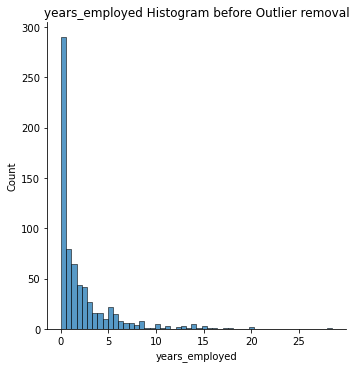

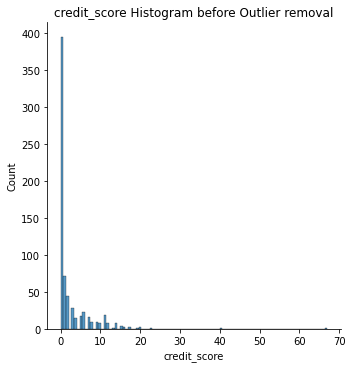

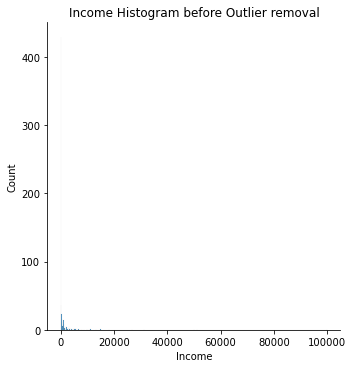

In [201]:
graph_columns=['years_employed','credit_score','Income']

for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot(df[col])
    plt.title(col + ' Histogram before Outlier removal')  

**Observatios:**
>- All the datatypes look appropriate according to the column name.
>- No column has null values
>- We can see all the histograms are highly skewed. Lets do the log transformation and check the histplots again
>- Before taking log we need to take care of 0 values as log 0 = -inf
>- So we will replace the 0 values in these 3 coulns with non zero minimum values for each column.

>[Go to Data Prep Outline](#data-prep)

In [202]:
df.loc[(df['Income'] == 0),'Income'] = min(df[df['Income'] > 0]['Income'])
df.loc[(df['years_employed'] == 0),'years_employed'] = min(df[df['years_employed'] > 0]['years_employed'])
df.loc[(df['credit_score'] == 0),'credit_score'] = min(df[df['credit_score'] > 0]['credit_score'])

In [203]:
df[(df['Income'] == 0) | (df['years_employed'] == 0) | (df['credit_score'] == 0)]

,approved,gender,age,debt,married,bank_customer,emp_industrial,emp_materials,emp_consumer_services,emp_healthcare,emp_financials,emp_utilities,emp_education,ethnicity_white,ethnicity_black,ethnicity_latino,ethnicity_asian,ethnicity_other,years_employed,prior_default,employed,credit_score,drivers_license,citizen_bybirth,citizen_other,citizen_temporary,Income


In [204]:
df['years_employed_log'] = np.log(df['years_employed'])
df['credit_score_log'] = np.log(df['credit_score'])
df['income_log'] = np.log(df['Income'])

<Figure size 432x288 with 0 Axes>

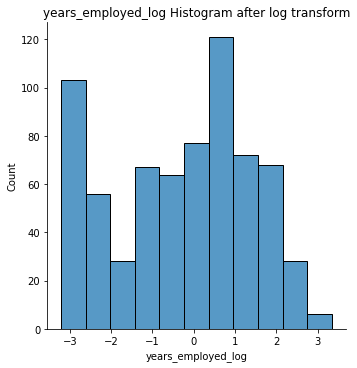

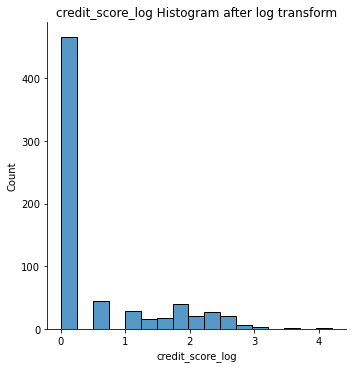

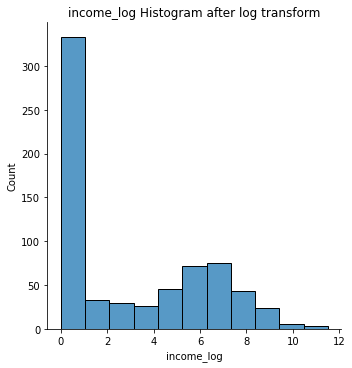

In [205]:
graph_columns=['years_employed_log','credit_score_log','income_log']

for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot(df[col])
    plt.title(col + ' Histogram after log transform') 

**Observation**

Skewness is reduced because of the log transform. We still need to normalize the data as we will be using kNN. Normalization will help the distribution of data further.

### 3.4 Feature Selection<a class="anchor" id="feature-selection"></a>

>- In most of the countries, lender cannot discriminate on basis of Age, Gender, Ethnicity of the applicant. Thus we will also remove these columns from out dataset.
>- Along with that we will drop the columns for which we have already taken the log transform.

>[Go to Data Prep Outline](#data-prep)

In [206]:
df.drop(columns=['age','gender','ethnicity_white', 'ethnicity_black', 'ethnicity_latino',
       'ethnicity_asian', 'ethnicity_other','years_employed','credit_score','Income'], inplace=True)

### 3.5 Data Partitioning<a class="anchor" id="data-partitioning"></a>

>- Put all potential predictor variables into new object called 'X'
>- Put target variable in new object called 'y'
>- Partition data into training set and testing set

>[Go to Data Prep Outline](#data-prep)

In [207]:
target = ['approved']

X = df.drop(target,axis=1)
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=10)

### 3.6 Data Normalization<a class="anchor" id="normalization"></a>

>- We do this AFTER splitting the data because we only want to use summary stats<br>
>- from the TRAINING data to normalize BOTH TRAIN and TEST data<br>
<br><br>
>OPTIONAL - though it is a good idea to get in the habit of doing this when working with the kNN classifier

>[Go to Data Prep Outline](#data-prep)

In [208]:
# Normalize predictor variables using Z-Scores.
# Use means and standard deviations of features as calculated in the TRAINING DATA
# New values are centered at 0.  Values reflect the number of standard deviations
# each record is above or below the mean.

features_means = X_train.mean()
features_std = X_train.std()

X_train = (X_train - features_means)/features_std
X_test = (X_test - features_means)/features_std

In [225]:
numerical_vars = ['debt','years_employed_log','credit_score_log','income_log']

summaryStats(X_train, numerical_vars)

Low debt                 -2.59
years_employed_log   -3.45
credit_score_log     -2.45
income_log           -3.63
dtype: float64
High debt                 2.32
years_employed_log   3.31
credit_score_log     2.43
income_log           3.64
dtype: float64


,mean,median,std_dev,min_val,max_val,null_values,lower_bound,upper_bound,outliers_from_IQR,outliers_from_Zscore
debt,0.00,-0.40,1.00,-0.96,4.33,0,-2.59,2.32,14,8
years_employed_log,0.00,0.18,1.00,-1.56,1.95,0,-3.45,3.31,0,0
credit_score_log,0.00,-0.62,1.00,-0.62,4.05,0,-2.45,2.43,8,1
income_log,0.00,-0.41,1.00,-0.91,2.62,0,-3.63,3.64,0,0


<Figure size 432x288 with 0 Axes>

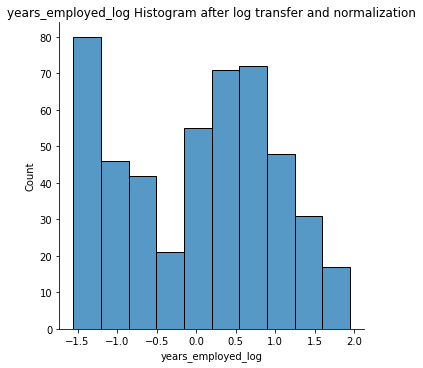

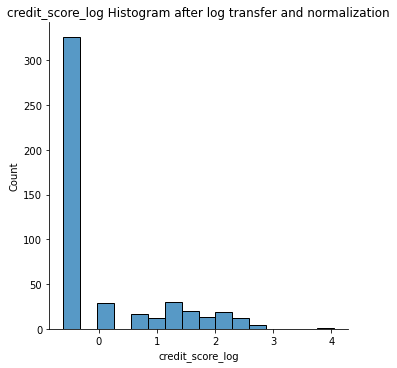

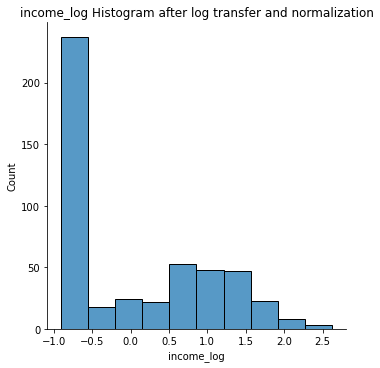

In [210]:
for i, col in enumerate(graph_columns):
    plt.figure(i)
    sns.displot((X_train[col]))
    plt.title(col + ' Histogram after log transfer and normalization')  

**Observation**

>- Data is normalized but as there are large number of 0 values in income and credit score columns, it is showing high count for lower values of income and credit score in the histogram. 
>- As we dont have large datapoints we will not remove these outliers for now

# 4. Machine Learning <a class="anchor" id="ml-model"></a>

- [X] [kNN](#kNN)
- [X] [Logistic Model](#lr-model)
- [X] [Decision Point](#decision-point)
- [x] [Performance Evaluation](#model-performance)


* [Go to Top](#table-of-content)

### 4.1 kNN<a class="anchor" id="kNN"></a>

>- Fit numerous kNN models using different values for k. <br>
>- Choose the "best" value for "k" based on Accuracy

In [211]:
# 1. train a classifier for different values of k
results = []
for k in np.arange(1,47,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train.values.ravel())
    
    # Get predicted class
    y_pred_class = knn.predict(X_test)
    
    # Put Accuracy Score in results object
    results.append({'k':k,
                    'accuracy':metrics.accuracy_score(y_test,y_pred_class),
                    'precision':metrics.precision_score(y_test,y_pred_class),
                    'recall':metrics.recall_score(y_test,y_pred_class)
                   }
                  )
# Put results from above into a Pandas Dataframe
results_df = pd.DataFrame(results)
results_df

,k,accuracy,precision,recall
0,1,0.81,0.85,0.70
1,3,0.83,0.86,0.74
2,5,0.84,0.85,0.79
3,7,0.84,0.84,0.79
4,9,0.85,0.87,0.78
5,11,0.84,0.88,0.76
6,13,0.83,0.87,0.73
7,15,0.84,0.87,0.76
8,17,0.82,0.85,0.72
9,19,0.83,0.86,0.73


<AxesSubplot:xlabel='k', ylabel='accuracy'>

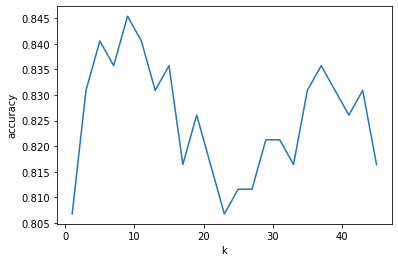

In [212]:
sns.lineplot(data=results_df, x='k',y='accuracy')

>**Decision:**<br>
>- Based on the results above, I will set my number of neighbors (k) to 9 as this is the lowest value that achieves the highest accuracy value along with good precision and recall

>**Re-run kNN using the value selected above:**<br>
For this final run of kNN, we will produce a table of performance measures across a range of probability threshold values

In [213]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train,y_train.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = knn.predict(X_train)
y_test_pred_class = knn.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))


Training data Accuracy: 0.85
Testing data Accuracy: 0.85


>- Model does not show any signs of overfitting as accuracy for test train is same

In [214]:
class_perf_measures(knn, X_test, y_test,0,1,0.1)

,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,94,0,113,0,45.63,0.00,54.85,0.00,0.45,1.00,0.45,0.62
1,0.10,92,44,69,2,44.66,21.36,33.50,0.97,0.57,0.98,0.66,0.72
2,0.20,89,75,38,5,43.20,36.41,18.45,2.43,0.70,0.95,0.79,0.81
3,0.30,85,87,26,9,41.26,42.23,12.62,4.37,0.77,0.90,0.83,0.83
4,0.40,80,97,16,14,38.83,47.09,7.77,6.80,0.83,0.85,0.86,0.84
5,0.50,73,102,11,21,35.44,49.51,5.34,10.19,0.87,0.78,0.85,0.82
6,0.60,62,105,8,32,30.10,50.97,3.88,15.53,0.89,0.66,0.81,0.76
7,0.70,52,108,5,42,25.24,52.43,2.43,20.39,0.91,0.55,0.77,0.69
8,0.80,43,110,3,51,20.87,53.40,1.46,24.76,0.94,0.46,0.74,0.61
9,0.90,33,111,2,61,16.02,53.88,0.97,29.61,0.94,0.35,0.70,0.51


**Terminology:**
>- TP: Loan is approved when in reality it should be approved
>- TN: Loan is rejected when in reality it should be rejected
>- FP: Loan is approved when in reality it should be rejected
>- FN: Loan is rejected when in reality is should be approved

* [Go to Machine Learning Model](#ml-model)

### 4.2 Logistic Model<a class="anchor" id="lr-model"></a>

>- Let's produce the same table above but this time using a Logistic Model

In [215]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

# Let's do a quick check to see if we have to worry about problems of overfitting.
# Remember!  Small values for "k" in kNN tend to lead to overfitting.
# Large value for "k" in kNN tend to produce underfit models
y_train_pred_class = lr_model.predict(X_train)
y_test_pred_class = lr_model.predict(X_test)

print('Training data Accuracy:', metrics.accuracy_score(y_train,y_train_pred_class).round(2))
print('Testing data Accuracy:', metrics.accuracy_score(y_test,y_test_pred_class).round(2))

Training data Accuracy: 0.87
Testing data Accuracy: 0.86


In [216]:
class_perf_measures(lr_model, X_test, y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,94,0,113,0,45.63,0.00,54.85,0.00,0.45,1.00,0.45,0.62
1,0.10,89,74,39,5,43.20,35.92,18.93,2.43,0.69,0.95,0.79,0.80
2,0.20,89,85,28,5,43.20,41.26,13.59,2.43,0.76,0.95,0.84,0.84
3,0.30,87,90,23,7,42.23,43.69,11.17,3.40,0.79,0.93,0.86,0.85
4,0.40,87,92,21,7,42.23,44.66,10.19,3.40,0.81,0.93,0.86,0.86
5,0.50,84,95,18,10,40.78,46.12,8.74,4.85,0.82,0.89,0.86,0.86
6,0.60,80,96,17,14,38.83,46.60,8.25,6.80,0.82,0.85,0.85,0.84
7,0.70,76,102,11,18,36.89,49.51,5.34,8.74,0.87,0.81,0.86,0.84
8,0.80,66,107,6,28,32.04,51.94,2.91,13.59,0.92,0.70,0.84,0.80
9,0.90,45,111,2,49,21.84,53.88,0.97,23.79,0.96,0.48,0.75,0.64


**Terminology:**
>- TP: Loan is approved when in reality it should be approved
>- TN: Loan is rejected when in reality it should be rejected
>- FP: Loan is approved when in reality it should be rejected
>- FN: Loan is rejected when in reality is should be approved

* [Go to Machine Learning Model](#ml-model)

### 4.3 Decision Point<a class="anchor" id="decision-point"></a>

Let's plot ROC curve for both the models and compare hte AUC. We will select the model with higher AUC

* [Go to Machine Learning Model](#ml-model)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


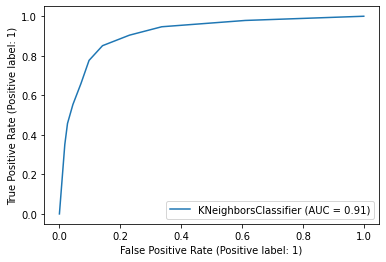

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


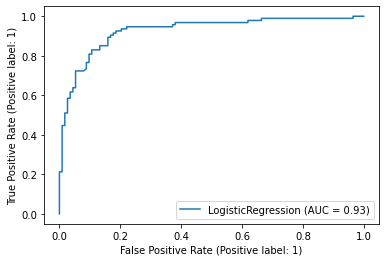

In [217]:
# ROC curve for kNN
metrics.plot_roc_curve(knn,X_test,y_test)
plt.show()

# ROC curve for Logistic Model
metrics.plot_roc_curve(lr_model,X_test,y_test)
plt.show()

AUC is more for our Logistic Model than kNN. Along with AUC Logistic model performs slightly better on the front of accuracy too. For now I will use Logistic model to further evaluate probability thresholds and corresponding performance measures

### 4.4 Model Performance<a class="anchor" id="model-performance"></a>

>- Let's chec the performance of the logistic model for different thresholds to find the best performing model

**Terminology:**
>- TP: Loan is approved when in reality it should be approved
>- TN: Loan is rejected when in reality it should be rejected
>- FP: Loan is approved when in reality it should be rejected
>- FN: Loan is rejected when in reality is should be approved

**Analyzing possibilities**
>- 1. Effects of FP:<br> 
    i.   Large number of customers will not be able to pay back the loan which mean large number of defaulters<br>
    ii.  NPAs will increase<br>
    iii. Customers will lose trust in bank and will take out the deposites causing liquidity issues for bank<br>
    iv.  When a customer defaults, bank can go ahead and sale the assets of the customer. This might require long legal procedure involving time, energy and money.<br>
>- 2. Effects of FN:<br>
    i.   Interests coming out of lendings is the primary source of income for banks. If bank fails to lend money to credit worthy customer then essentially it means bank is losing on money<br>

**Decision**   
>- In this case, the cost of FP is more than the cost of FN. If we reject a loan for a credit worthy customer then we might lose on some interest amount which we could have been benefited from the loan. But in case of FP we apporve loan for non credit worthy customers. This will result in large number of defaulters. In this case, bank will not only have to forget the profit but have to spend extra in liquifying asses of defaulter customers.
>- FP is the costly perameter. Thus we want to minimise the FP and maximise the precision. 

In [218]:
class_perf_measures(lr_model, X_test, y_test,0,1,0.1)

C:\Users\kchapork\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,threshold,TP,TN,FP,FN,TP%,TN%,FP%,FN%,Precision,Recall,Accuracy,F1
0,0.00,94,0,113,0,45.63,0.00,54.85,0.00,0.45,1.00,0.45,0.62
1,0.10,89,74,39,5,43.20,35.92,18.93,2.43,0.69,0.95,0.79,0.80
2,0.20,89,85,28,5,43.20,41.26,13.59,2.43,0.76,0.95,0.84,0.84
3,0.30,87,90,23,7,42.23,43.69,11.17,3.40,0.79,0.93,0.86,0.85
4,0.40,87,92,21,7,42.23,44.66,10.19,3.40,0.81,0.93,0.86,0.86
5,0.50,84,95,18,10,40.78,46.12,8.74,4.85,0.82,0.89,0.86,0.86
6,0.60,80,96,17,14,38.83,46.60,8.25,6.80,0.82,0.85,0.85,0.84
7,0.70,76,102,11,18,36.89,49.51,5.34,8.74,0.87,0.81,0.86,0.84
8,0.80,66,107,6,28,32.04,51.94,2.91,13.59,0.92,0.70,0.84,0.80
9,0.90,45,111,2,49,21.84,53.88,0.97,23.79,0.96,0.48,0.75,0.64


1. **Prob Threshold = 0.2**:

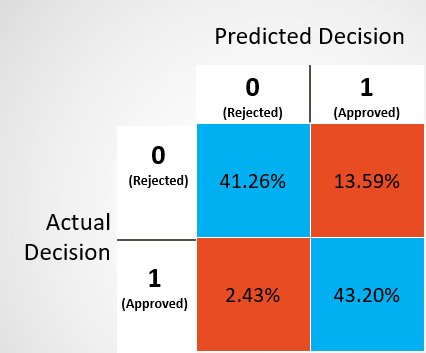

- Here threshold is 0.2 which means if probability of loan aprroval is more than 0.2 then we will approve the loan. As this threshold is very low we expect very high percentage of positive predictions and we can see p% = 13 + 43 = 56%
- In this case false positive means that loan is approved when it shouldn't be. Where as false negative means loan is rejected when it should be approved.
- We have already discussed that FP are more costly than FN
- For 0.2 threshold, our model is predicting correctly for 84% of the times, for 13.59% times model is approving the loan when it should be rejected and 2.43% of the time it is rejecting the loan when it should be approved.
- Here precision is not very high, recall is very good. Accuracy also seems to be good. We will check other thresholds and decide the threshold later.

<br>

2. **Prob Threshold = 0.5**:

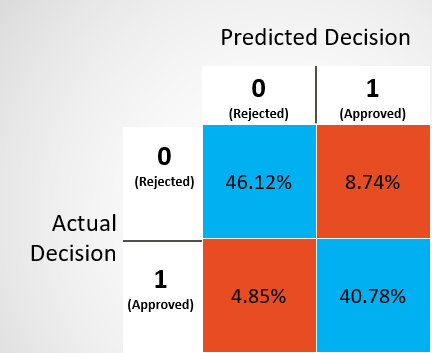

- Here threshold is 0.5 which means if probability of approving loan is more than 0.5 then we will approve it.
- Here precision which is the primary performance parameter in our case is 0.82 that is 16% more than the precision for th = 0.2
- Even though recall is reduced by 9%, the accuracy and precision both are improving cosiderably. 
- For this threshold, we will be accepting bad loan for 8.74% of time and rejectig good loan for 5% of the time where as model is making a correct decision for 82% of the time.
- Approving bad loans for 7% of the times is not advisable.
- Looking at the credit data in US we can see generally 3-4% of loans gets defaulted.
- As the FPs are the costly parameters, we should try to make them lesser than FNs while keeping the FNs low. For that we can try high value of threshold.
<br><br>

3. **Prob Threshold = 0.8**:

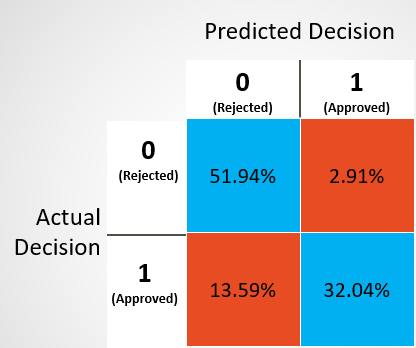

- Here threshold is 0.8 which means if probability of loan approval is more than 0.8 then we will approve the loan. As this threshold is very high we expect very high percentage of negative predictions and we can see N% = 52 + 14 = 66%
- For this threshold, FP% is 2.9% but FN% is 15.59%. 
- This threshold is giving very high precision as FPs are only 2.9% but it is performing badly on the accuracy as well as recall front. This means we will stop giving bad loans but we will fail to give good loans for 13.59% of the time which doesnt sound good.
<br><br>
4. **Best threshold**
    - Considering all the thresold, 0.8 looks like the best scenario. 
    - We will be handing out bad loans for 3% of the the time. If we look at the graph of deafuted loan % attached on the top, we can see arounf 11% of student loans are defaulted and 7% credit cards are defaulted but only 2-3% of the rest of the loans are defaulted.
    - Thus, assuming the bank dispurses all types of loans, threshold should be kept at 0.8. If bank only focuses on student loans then we can keep the th=0.5 as we want to give loans to more and more number students. Even though defaulter will be slightly more (7%) in this case, but percentage of false negative will also go down. 
    - One suggestion would be cosidering data about type of loan in the model which can solve this issue.
    - As the data consists job information, it suggests that the dataset is not for student loan exclusively. At the same time some of the applicants have 0 income suggesting they might be stuents. Thus it looks like dataset contains all type of loans. Thats why I will be cosidering th=0.8
    
* [Go to Machine Learning Model](#ml-model)

# 5. Deployment <a class="anchor" id="model-deployment"></a>

* [Go to Top](#table-of-content)

In [219]:
import pickle
pickle_out = open('loanApproval', mode='wb')
pickle.dump([knn, lr_model, features_means, features_std, X_test.columns], pickle_out)
pickle_out.close()

In [220]:
%%writefile app.py

import pickle
import streamlit as st
import math
import pandas as pd
import numpy as np

pickle_in = open('loanApproval', 'rb')
knn, lr_model, features_means, features_std, features = pickle.load(pickle_in)

@st.cache()

# Define the function which will make the prediction using data
# inputs from users

def prediction(classifier, debt, marrital_status, bank_customer, employment_type, prior_default, employment, drivers_license,
               citizenship, years_employed, credit_score, income):
    
    #Populating the booleans
    marrital_status = 1 if marrital_status == 'Yes' else 0
    bank_customer = 1 if bank_customer == 'Yes' else 0
    prior_default = 0 if prior_default == 'Yes' else 1    #prior_defaulters are identified as 0 in the dataset
    employment = 1 if employment == 'Yes' else 0
    drivers_license = 1 if drivers_license == 'Yes' else 0
    
    #taking log transform
    years_employed = np.log(years_employed)
    credit_score = np.log(credit_score)
    income = np.log(income)
    
    #initialization
    employment_types = {'Industrial':0,
                'Materials':0,
                'Consumer Services':0,
                'Healthcare':0,
                'Financials':0,
                'Education':0,
                'Utilities':0}
    
    citizenships = {'Citizen By Birth':0,
                    'Temporary Citizenship':0,
                    'Other':0}
    
    #value population
    for key in employment_types:
        if key == employment_type:
            employment_types[key] = 1
            
    for key in citizenships:
        if key == citizenship:
            citizenships[key] = 1
            
    X_test_df = pd.DataFrame([[debt, marrital_status, bank_customer, 
                               employment_types.get('Industrial'),employment_types.get('Materials'),employment_types.get('Consumer Services'),
                               employment_types.get('Healthcare'),employment_types.get('Financials'),employment_types.get('Education'),
                               employment_types.get('Utilities'),
                               prior_default, employment, drivers_license,
                               citizenships.get('Citizen By Birth'), citizenships.get('Temporary Citizenship'),citizenships.get('Other'),
                               years_employed, credit_score, income]], 
        columns=features)
    
    #normalise the test data
    X_test_df = (X_test_df - features_means)/features_std
    
    # Make predictions
    message = ''
    if classifier == 'Logistic Regression':
        prediction = lr_model.predict_proba(X_test_df)
        THRESHOLD = 0.8
    else: 
        prediction = knn.predict_proba(X_test_df)
        THRESHOLD = 0.6
        message = 'AUC for Log Reg is more than AUC for kNN. Accuracy is also better for log reg thus prefer Log Reg'

    if prediction[0][1] > THRESHOLD:
        return ['Your loan is approved :)',message]
    else: 
        return ['Sorry your loan is rejected :(',message]

# This is the main function in which we define our webpage
def main():
    
    st.title('Jarvis Loan Approval System')
    # Create input fields
    classifier = st.radio("Which model you want to use for prediction?",
                            ('kNN','Logistic Regression'))
    
    marrital_status = st.radio('Is the customer married?',
                             ('Yes','No'))
    
    bank_customer = st.radio('Is the borrower already bank customer',
                             ('Yes','No'))
    
    prior_default = st.radio('Is the borrower prior defaulter?',
                             ('Yes','No'))
    
    employment = st.radio('Is the borrower employed?',
                             ('Yes','No'))
    
    drivers_license = st.radio('Does the borrower have drivers license?',
                             ('Yes','No'))
    
    debt = st.number_input("How much debt does borrower already have in $1000s?",
                                  min_value=0.000,
                                  max_value=30.000,
                                  value=10.000,
                                  step=2.500,
                                 )
    
    employment_type = st.selectbox('Select the employment type',
                             ('Industrial','Materials','Consumer Services','Healthcare','Financials','Utilities','Education'))
    
    citizenship = st.selectbox('Does borrower have US citizenship?',
                             ('Citizen By Birth','Temporary Citizenship','Other'))
               
    years_employed = st.number_input("For how many years the borrower has been employed?",
                                  min_value=1.0,
                                  max_value=30.0,
                                  value=10.0,
                                  step=1.0,
                                 )
    
    credit_score = st.number_input("What is the credit score of borrower?",
                                  min_value=1.0,
                                  max_value=70.0,
                                  value=10.0,
                                  step=5.0,
                                 )
    
    income = st.number_input("What is the income of borrower?",
                                  min_value=1,
                                  max_value=50000,
                                  value=30000,
                                  step=5000,
                                 )
               
    result = ""
    
    # When 'Predict' is clicked, make the prediction and store it
    if st.button("Should be approve the loan?"):
        result = prediction(classifier, debt, marrital_status, bank_customer, employment_type, prior_default, employment, drivers_license,
               citizenship, years_employed, credit_score, income)
        st.success(result[0])
        if classifier == 'kNN':
            st.success(result[1])
        
if __name__=='__main__':
    main()

Overwriting app.py


In [221]:
!streamlit run app.py